# PPG Data

In [30]:
import numpy as np
import csv
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 30]
import matplotlib.pyplot as plt
from scipy import signal 

In [31]:
# opening the CSV file
with open('example_data.csv', 'r') as file:
  headers = next(file) # skip header 
  # reading the CSV file
  csvFile = csv.reader(file)
  data = list(csvFile)

data_array = np.array(data, dtype = 'float')

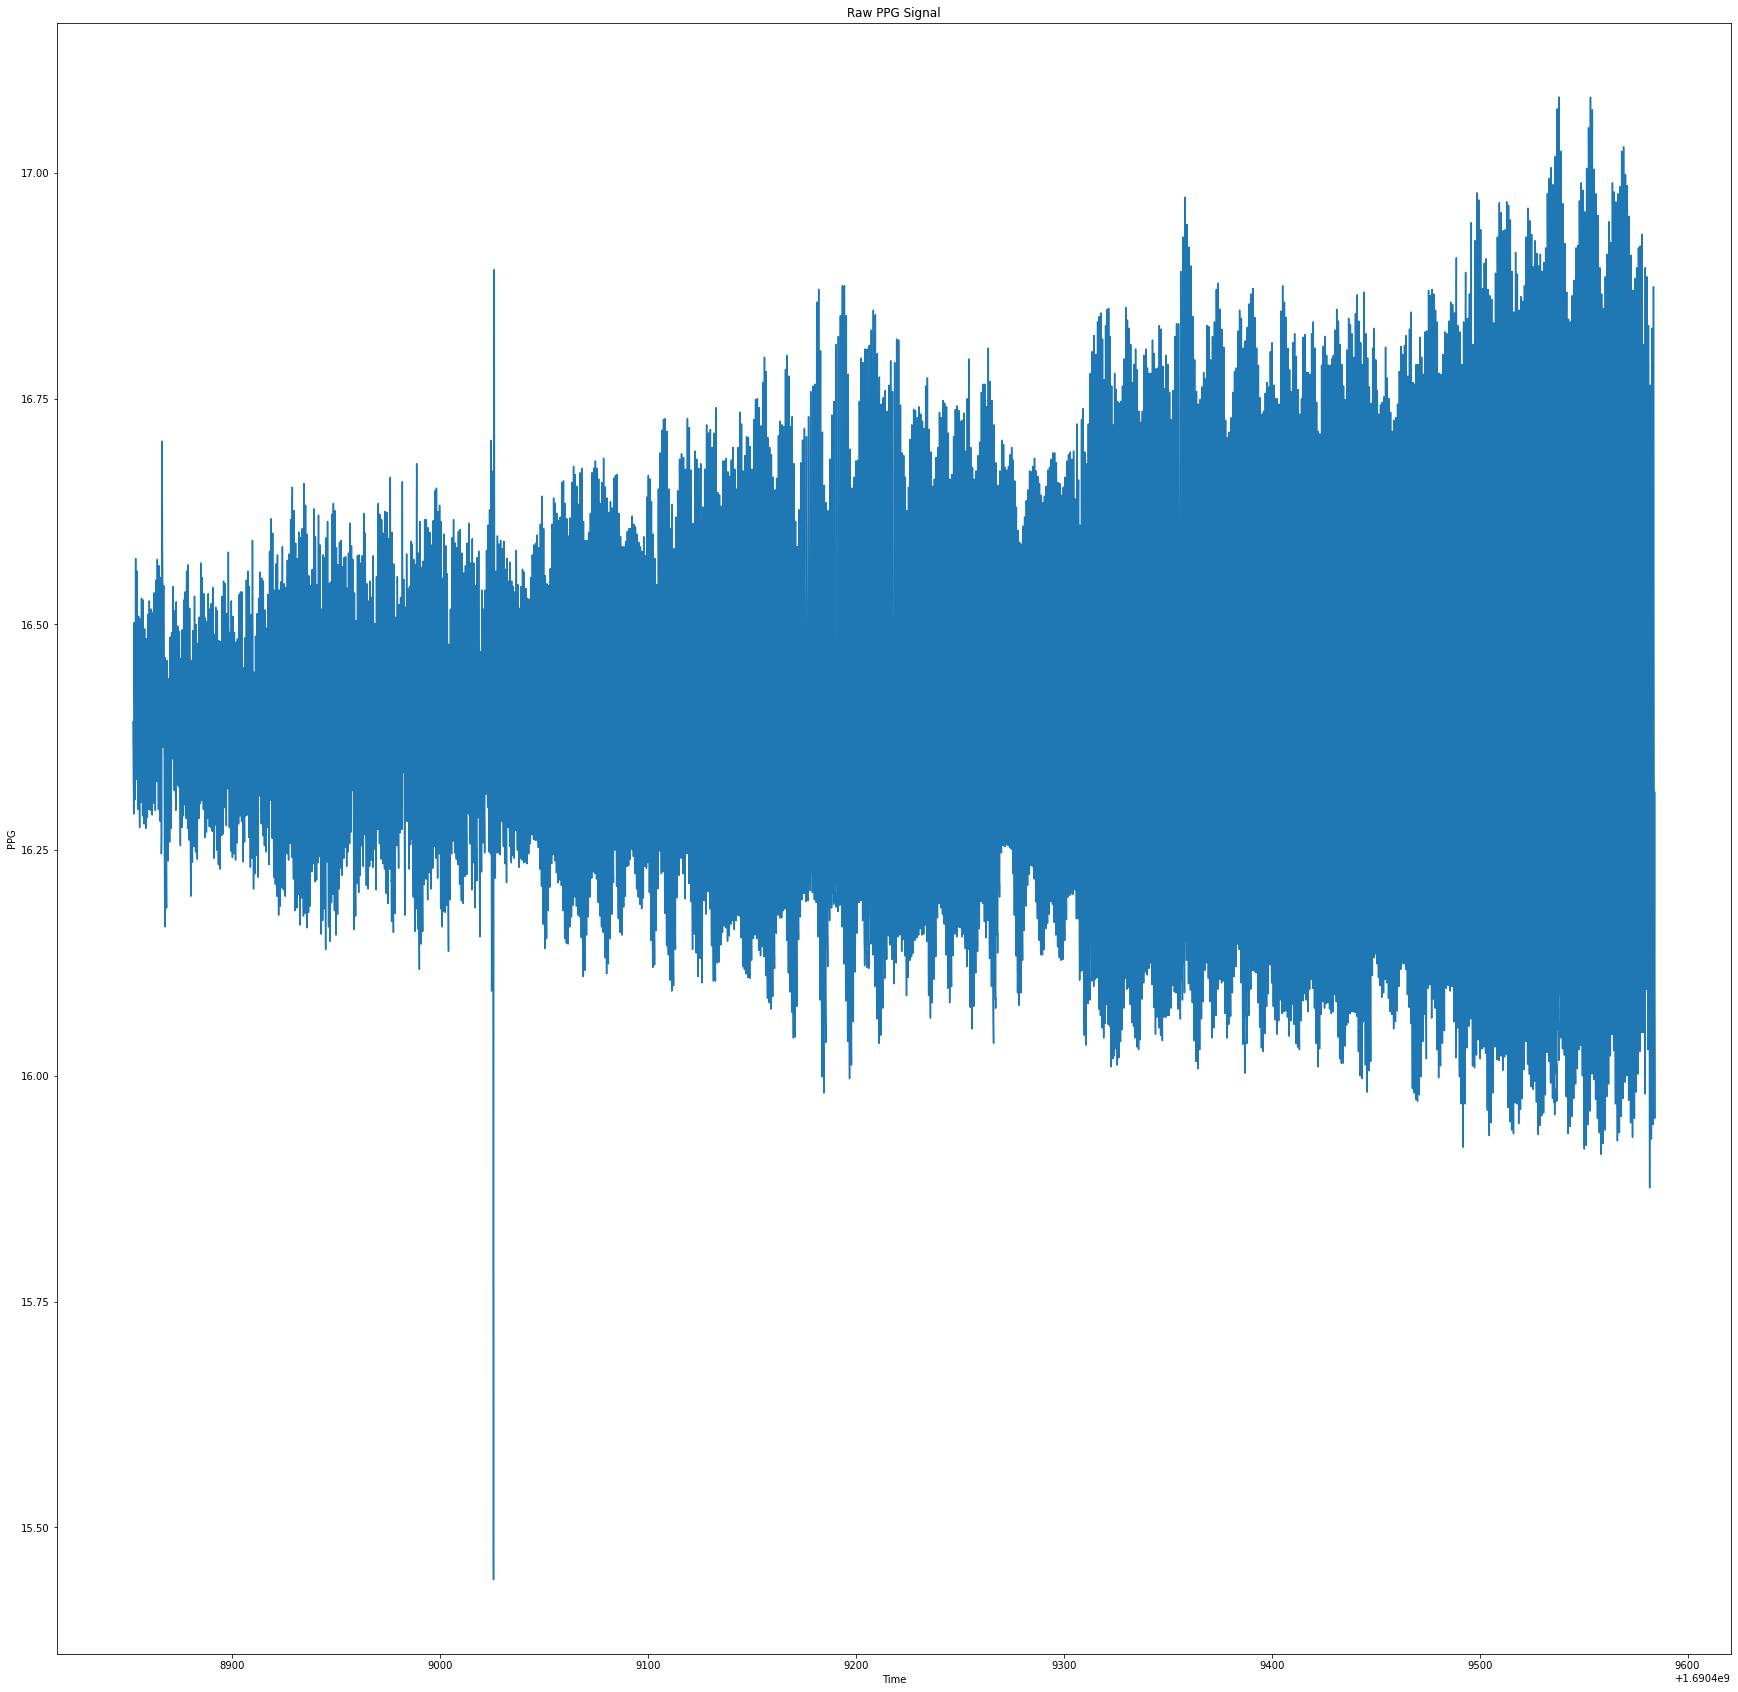

In [126]:
plt.plot(data_array[:,0], data_array[:,1])
plt.xlabel('Time')
plt.ylabel('PPG')
plt.title('Raw PPG Signal')
plt.ion()
plt.show()

## Preprocessing

In [127]:
# Bandpass filter to increase SNR
sampling_freq = 100
def bandpass_filt(ppg, bp_low, bp_high, N):  
    bp_filter = signal.butter(N, [bp_low, bp_high], 'bandpass', fs =sampling_freq, output='sos')
    # Normalize? 
    # Reduce baseline wander 
    zeroed_ppg = ppg - np.mean(ppg)
    return signal.sosfilt(bp_filter, zeroed_ppg)

# Moving Average Filter 
def moving_avg_filt(ppg,fs): #(https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection/blob/main/Pan_Tompkins.ipynb)
    # average on windows of 150ms (0.15*100)
    result = ppg.copy()
    window_size = round(0.15*fs)
    sum = 0 
    # sum for first N terms
    for j in range(window_size): 
        sum += ppg[j]/window_size
        result[j] = sum 
        
    # moving window integraiton
    for index in range(window_size,len(ppg)): 
        sum += ppg[index]/window_size
        sum -= ppg[index-window_size]/window_size
        result[index] = sum 
        
    return result   
    
# Peak Detection
def peak_detection(ppg): 
    
    peak_idxs = []
    # Peak detection 
    #     peak_idxs = []
    #     peak_idx = None
    #     peak_val = None
    #     baseline = np.mean(ppg)
    #     for idx in range(len(ppg)): 
    #         val = ppg[idx]
    #         if (val > baseline): 
    #             if (peak_val == None) or (val > peak_val):
    #                 peak_idx = idx
    #                 peak_val = val 
    #         elif (val < baseline) and (peak_idx != None): 
    #             peak_idxs.append(peak_idx)
    #             peak_idx = None
    #             peak_val = None

    #         if peak_idx != None: 
    #             peak_idxs.append(peak_idx)
    
    
    peak_idxs,properties = signal.find_peaks(ppg, prominence=1e-5)
    prom = signal.peak_prominences(ppg, peak_idxs)[0]
    #print(prom)
    
#     # FFT convolution
#     slopes = signal.fftconvolve(ppg, np.full((25,), 1) / 25, mode='same')

#     # Finding approximate peak locations
#     for i in range(round(0.5*sampling_freq) + 1,len(slopes)-1):
#         if (slopes[i] > slopes[i-1]) and (slopes[i+1] < slopes[i]):
#             peak_idxs.append(i)  

    return peak_idxs 

    
# Heart Rate Estimation
def hr_detection(t,ppg,peak_idxs):
    interbeat_interval = np.mean(np.diff(t[peak_idxs])) 
    return [60/interbeat_interval, interbeat_interval]

    

# Describe preprocessing techniques 
Pan Tompkins and other references 

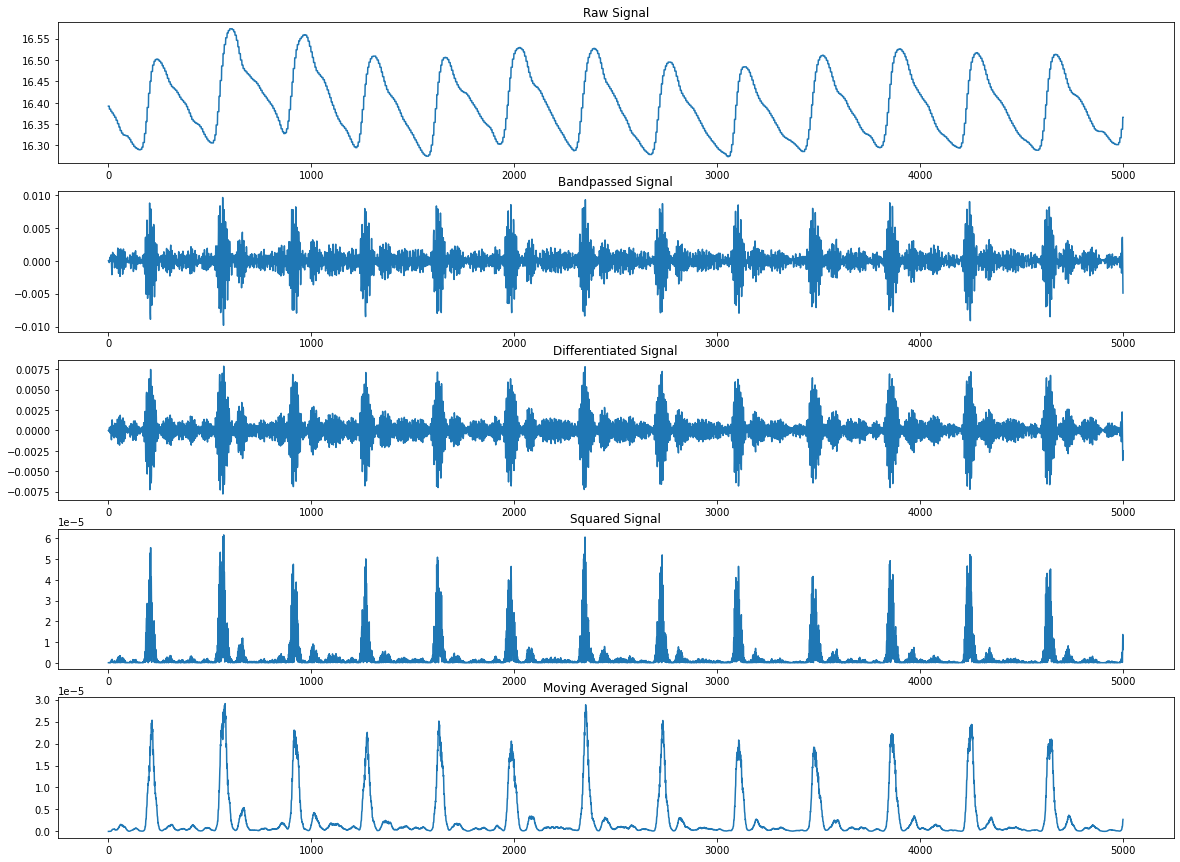

In [114]:
# Preprocess Test 
t = data_array[:5000,0]
ppg = data_array[:5000,1]

# Bandpass
bp_ppg = bandpass_filt(ppg, 5, 15, 5) # bandpass filter freq limits suggested by https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm
# Differentiate
diff_ppg = np.diff(bp_ppg)
# Square
square_ppg = np.square(diff_ppg)
# Moving average
moving_avg_ppg = moving_avg_filt(square_ppg, sampling_freq)

plt.figure(figsize=(20,15))
plt.subplot(511)
plt.plot(ppg)
plt.title('Raw Signal')
plt.subplot(512)
plt.plot(bp_ppg)
plt.title('Bandpassed Signal')
plt.subplot(513)
plt.plot(diff_ppg)
plt.title('Differentiated Signal')
plt.subplot(514)
plt.plot(square_ppg)
plt.title('Squared Signal')
plt.subplot(515)
plt.plot(moving_avg_ppg)
plt.title('Moving Averaged Signal')
plt.show()

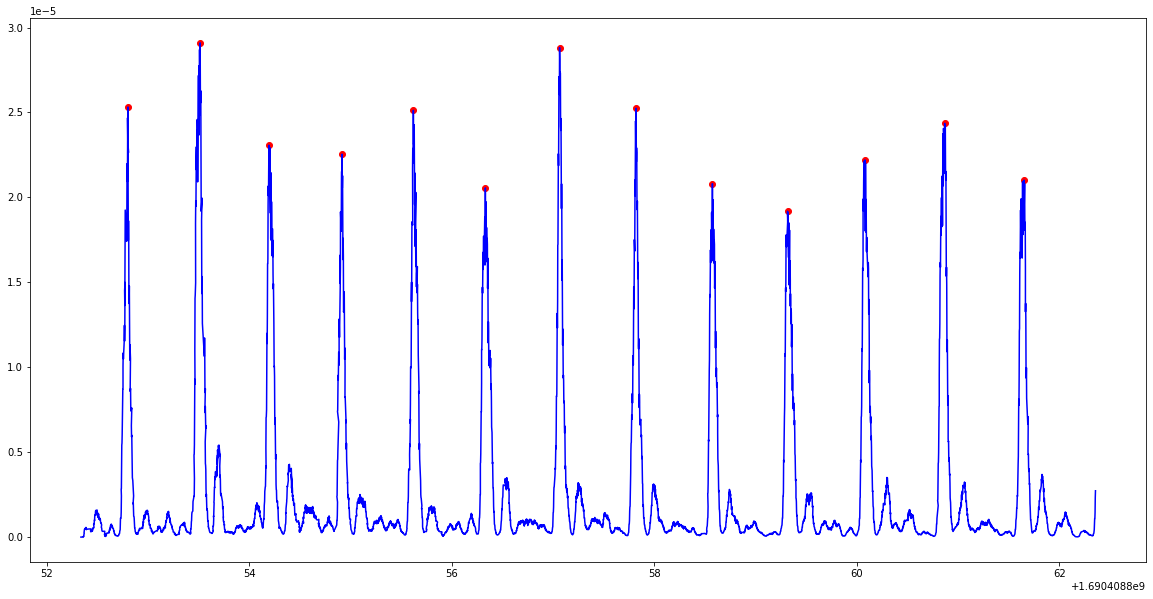

In [115]:
# Peak Detection Test
peak_idxs = peak_detection(moving_avg_ppg)
[heart_rate,_] = hr_detection(t,moving_avg_ppg,peak_idxs)
plt.figure(figsize=(20,10))
plt.ion()
plt.plot(t[:-1],moving_avg_ppg,c='b')
plt.scatter(t[peak_idxs], moving_avg_ppg[peak_idxs],c='r')
plt.show()

In [125]:
print("Estimated Heart Rate: ", heart_rate)

Estimated Heart Rate:  79.64525490144212


In [117]:
n = np.size(data_array,0)
end_idx = 0 
start_idx = 0
bin_size = 5000
heart_rates = []
ib_ints = []
start_idxs = []
while (start_idx != None): 
    start_idx = end_idx
    start_idxs.append(start_idx)
    end_idx = start_idx + bin_size
    if (end_idx >= n): 
        end_idx = n
        start_idx = None 
    t = data_array[start_idx:end_idx,0]
    ppg = data_array[start_idx:end_idx,1]
    peak_idxs = peak_detection(ppg)
    [heart_rate,ib_int] = hr_detection(t,ppg,peak_idxs)
    heart_rates.append(heart_rate)
    ib_ints.append(ib_int)


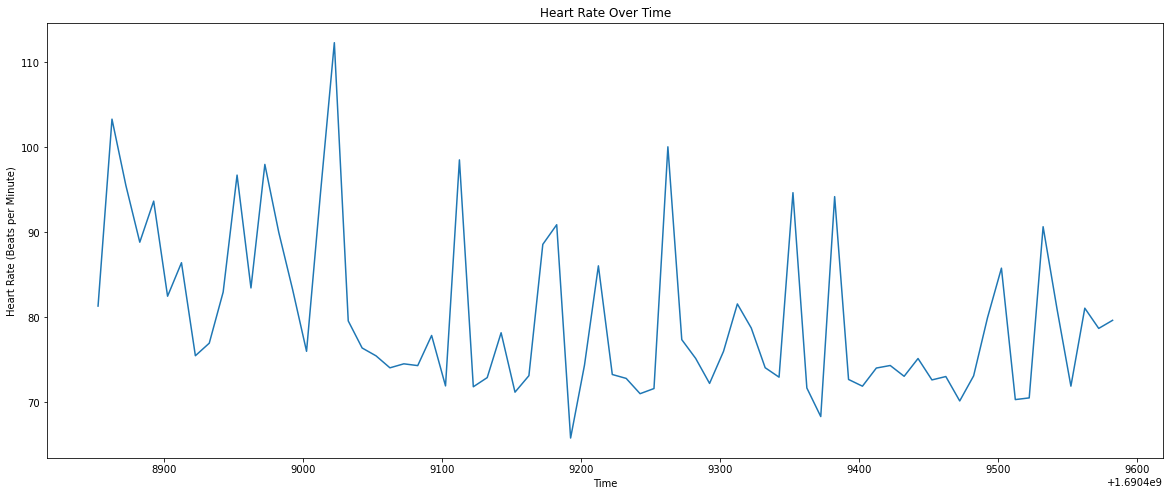

In [131]:
t = data_array[:,0]
plt.figure(figsize=(20,8))
plt.title('Heart Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heart Rate (Beats per Minute)')
plt.plot(t[start_idxs], heart_rates)
plt.show()

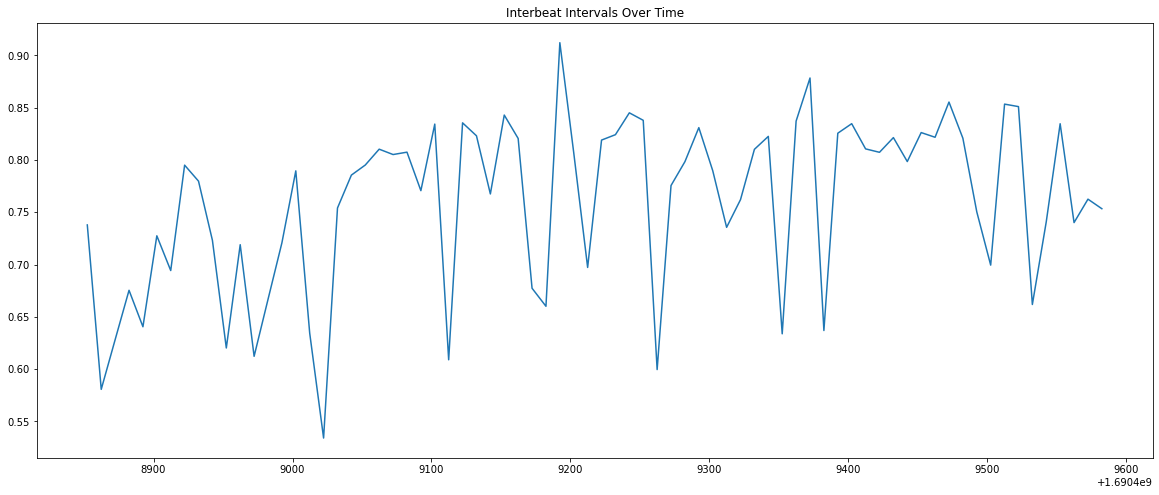

In [128]:
t = data_array[:,0]
plt.figure(figsize=(20,8))
plt.title('Interbeat Intervals Over Time')
plt.plot(t[start_idxs], ib_ints)
plt.show()

In [132]:
# Heart Rate Variability
print(np.var(ib_ints))

0.0066745043548381245
